In [3]:
import pandas as pd 
charging_sessions=pd.read_csv(r"C:\Users\gargr\Downloads\ev_charging_dataset\charging_sessions.csv")
charging_stations=pd.read_csv(r"C:\Users\gargr\Downloads\ev_charging_dataset\charging_stations.csv")
customers=pd.read_csv(r"C:\Users\gargr\Downloads\ev_charging_dataset\customers.csv")
districts=pd.read_csv(r"C:\Users\gargr\Downloads\ev_charging_dataset\districts.csv")

In [7]:
charging_sessions

,session_id,customer_id,station_id,session_start_time,kwh_charged,cost_per_kwh,total_cost
0,S00001,C3806,18,2025-10-04 05:42:00,46.691971,1.851397,86.445363
1,S00002,C4931,98,2025-10-19 16:12:00,39.061716,3.256199,127.192717
2,S00003,C2250,145,2025-09-14 15:18:00,30.280525,2.704520,81.894289
3,S00004,C3790,165,2025-10-06 23:22:00,44.577079,1.851397,82.529859
4,S00005,C4834,68,2025-09-26 09:07:00,37.998209,2.704520,102.766920
...,...,...,...,...,...,...,...
113995,S113996,C7127,70,2025-10-24 11:32:00,33.221606,2.704520,89.848502
113996,S113997,C1406,131,2025-09-04 00:41:00,55.850678,1.851397,103.401763
113997,S113998,C2269,14,2025-10-29 14:11:00,44.547895,2.704520,120.480680
113998,S113999,C5246,155,2025-10-22 10:19:00,30.946160,2.704520,83.694513


In [9]:
charging_sessions['session_start_time']=pd.to_datetime(charging_sessions['session_start_time'],errors='coerce')

In [11]:
charging_sessions=charging_sessions.dropna(subset=['session_start_time'])
charging_sessions=charging_sessions.drop_duplicates()
charging_sessions.isnull().sum()

session_id            0
customer_id           0
station_id            0
session_start_time    0
kwh_charged           0
cost_per_kwh          0
total_cost            0
dtype: int64

In [13]:
charging_sessions["Date"]=charging_sessions['session_start_time'].dt.date
charging_sessions

,session_id,customer_id,station_id,session_start_time,kwh_charged,cost_per_kwh,total_cost,Date
0,S00001,C3806,18,2025-10-04 05:42:00,46.691971,1.851397,86.445363,2025-10-04
1,S00002,C4931,98,2025-10-19 16:12:00,39.061716,3.256199,127.192717,2025-10-19
2,S00003,C2250,145,2025-09-14 15:18:00,30.280525,2.704520,81.894289,2025-09-14
3,S00004,C3790,165,2025-10-06 23:22:00,44.577079,1.851397,82.529859,2025-10-06
4,S00005,C4834,68,2025-09-26 09:07:00,37.998209,2.704520,102.766920,2025-09-26
...,...,...,...,...,...,...,...,...
113995,S113996,C7127,70,2025-10-24 11:32:00,33.221606,2.704520,89.848502,2025-10-24
113996,S113997,C1406,131,2025-09-04 00:41:00,55.850678,1.851397,103.401763,2025-09-04
113997,S113998,C2269,14,2025-10-29 14:11:00,44.547895,2.704520,120.480680,2025-10-29
113998,S113999,C5246,155,2025-10-22 10:19:00,30.946160,2.704520,83.694513,2025-10-22


In [15]:
# Aggregate daily total kWh
daily_energy = (
    charging_sessions
    .groupby('Date')['kwh_charged']
    .sum()
    .reset_index()
)


In [17]:
# Rename columns for Prophet
daily_energy.columns = ['ds', 'y']

# Convert ds back to datetime
daily_energy['ds'] = pd.to_datetime(daily_energy['ds'])

daily_energy.head()

,ds,y
0,2025-08-11,47912.260716
1,2025-08-12,49581.708464
2,2025-08-13,47218.137331
3,2025-08-14,51610.144113
4,2025-08-15,50269.243128


# Future Forecasting - EV demand in future 

In [19]:
pip install Prophet

Note: you may need to restart the kernel to use updated packages.


In [21]:
from prophet import Prophet
model=Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False
)
model.fit(daily_energy)
future=model.make_future_dataframe(periods=30)
forecast=model.predict(future)

23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:06 - cmdstanpy - INFO - Chain [1] done processing


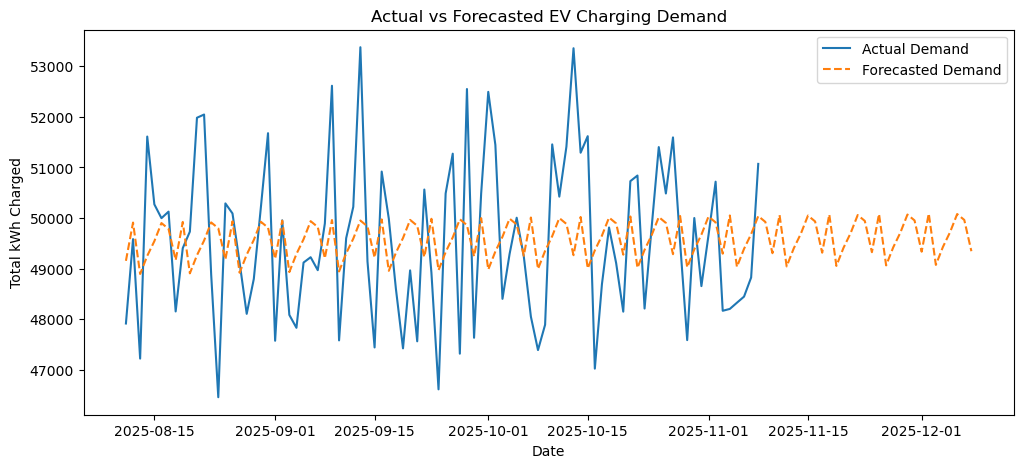

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))

plt.plot(daily_energy['ds'], daily_energy['y'], label='Actual Demand')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecasted Demand', linestyle='--')

plt.title("Actual vs Forecasted EV Charging Demand")
plt.xlabel("Date")
plt.ylabel("Total kWh Charged")
plt.legend()

plt.show()

# Regression - For predicting total cost of charging  session

In [23]:
import pandas as pd

# Reload your original dataset


# Ensure datetime
charging_sessions['session_start_time'] = pd.to_datetime(
    charging_sessions['session_start_time']
)

# Create time features
charging_sessions['hour'] = charging_sessions['session_start_time'].dt.hour
charging_sessions['day_of_week'] = charging_sessions['session_start_time'].dt.dayofweek

# Encode station_id (only once)
charging_sessions = pd.get_dummies(
    charging_sessions,
    columns=['station_id'],
    drop_first=True
)

In [27]:
charging_sessions

,session_id,customer_id,session_start_time,kwh_charged,cost_per_kwh,total_cost,Date,hour,day_of_week,station_id_13,...,station_id_156,station_id_157,station_id_159,station_id_160,station_id_163,station_id_164,station_id_165,station_id_175,station_id_176,station_id_182
0,S00001,C3806,2025-10-04 05:42:00,46.691971,1.851397,86.445363,2025-10-04,5,5,False,...,False,False,False,False,False,False,False,False,False,False
1,S00002,C4931,2025-10-19 16:12:00,39.061716,3.256199,127.192717,2025-10-19,16,6,False,...,False,False,False,False,False,False,False,False,False,False
2,S00003,C2250,2025-09-14 15:18:00,30.280525,2.704520,81.894289,2025-09-14,15,6,False,...,False,False,False,False,False,False,False,False,False,False
3,S00004,C3790,2025-10-06 23:22:00,44.577079,1.851397,82.529859,2025-10-06,23,0,False,...,False,False,False,False,False,False,True,False,False,False
4,S00005,C4834,2025-09-26 09:07:00,37.998209,2.704520,102.766920,2025-09-26,9,4,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,S113996,C7127,2025-10-24 11:32:00,33.221606,2.704520,89.848502,2025-10-24,11,4,False,...,False,False,False,False,False,False,False,False,False,False
113996,S113997,C1406,2025-09-04 00:41:00,55.850678,1.851397,103.401763,2025-09-04,0,3,False,...,False,False,False,False,False,False,False,False,False,False
113997,S113998,C2269,2025-10-29 14:11:00,44.547895,2.704520,120.480680,2025-10-29,14,2,False,...,False,False,False,False,False,False,False,False,False,False
113998,S113999,C5246,2025-10-22 10:19:00,30.946160,2.704520,83.694513,2025-10-22,10,2,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
station_cols = [col for col in charging_sessions.columns if col.startswith('station_id_')]

features = ['kwh_charged', 'hour', 'day_of_week'] + station_cols

X = charging_sessions[features]
y = charging_sessions['total_cost']

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [33]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [35]:
pred = model.predict(X_test)

In [37]:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(y_test, pred)
mae = mean_absolute_error(y_test, pred)

print("R2 Score:", r2)
print("MAE:", mae)

R2 Score: 0.7598814901486881
MAE: 14.137788521669437


# Clustering - segment customers into groups based on their charging habits and pattern

In [39]:
customer_data = charging_sessions.groupby('customer_id').agg({
    'kwh_charged': 'sum',
    'total_cost': 'mean',
    'hour': 'mean',
    'session_id': 'count'
}).reset_index()

customer_data.rename(columns={
    'session_id': 'total_sessions'
}, inplace=True)

customer_data.head()

,customer_id,kwh_charged,total_cost,hour,total_sessions
0,C0001,960.173651,127.495168,13.210526,19
1,C0002,854.661415,129.982797,12.833333,18
2,C0003,711.942445,112.370089,12.058824,17
3,C0004,1049.066518,160.592235,13.117647,17
4,C0005,824.186706,142.543074,12.733333,15


In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_data = scaler.fit_transform(
    customer_data[['kwh_charged', 'total_cost', 'hour', 'total_sessions']]
)

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
customer_data['cluster'] = kmeans.fit_predict(scaled_data)

customer_data.head()

,customer_id,kwh_charged,total_cost,hour,total_sessions,cluster
0,C0001,960.173651,127.495168,13.210526,19,1
1,C0002,854.661415,129.982797,12.833333,18,1
2,C0003,711.942445,112.370089,12.058824,17,1
3,C0004,1049.066518,160.592235,13.117647,17,1
4,C0005,824.186706,142.543074,12.733333,15,1


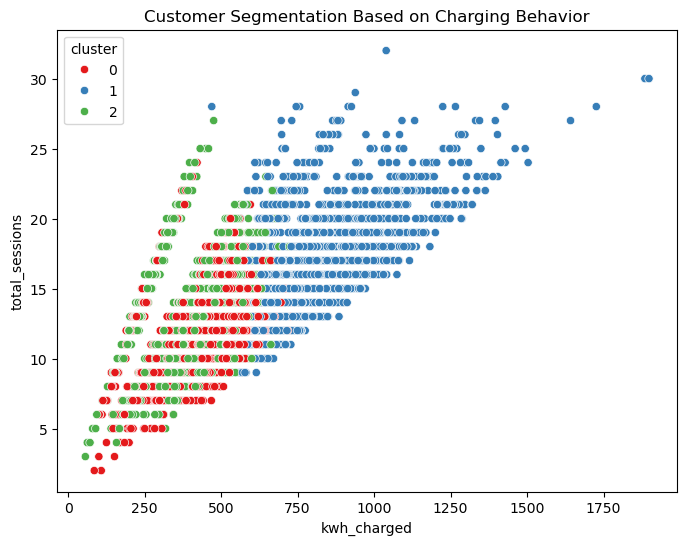

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=customer_data,
    x='kwh_charged',
    y='total_sessions',
    hue='cluster',
    palette='Set1'
)
plt.title("Customer Segmentation Based on Charging Behavior")
plt.show()


In [85]:
customer_data["cluster"].value_counts()

cluster
1    2779
0    2691
2    2530
Name: count, dtype: int64

In [67]:
customer_data.groupby("cluster").mean(numeric_only=True)


,kwh_charged,total_cost,hour,total_sessions
cluster,,,,
0,435.964221,94.030383,13.434911,12.432181
1,805.608250,123.494531,12.078280,17.075207
2,414.347836,81.182825,10.681366,13.080237


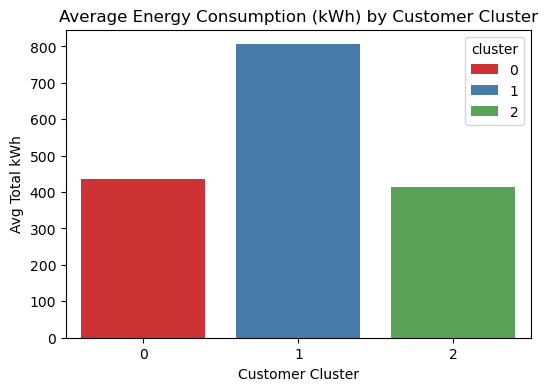

In [75]:
cluster_summary = customer_data.groupby('cluster').mean(numeric_only=True).reset_index()

plt.figure(figsize=(6,4))

sns.barplot(
    data=cluster_summary,
    x='cluster',
    y='kwh_charged',
    hue='cluster',
    palette='Set1'
)

plt.title("Average Energy Consumption (kWh) by Customer Cluster")
plt.xlabel("Customer Cluster")
plt.ylabel("Avg Total kWh")
plt.show()